In [97]:
# HELPER FUNCTIONS

import collections

def get_mean_metrics(models, metric_type):
    mean_acc_fedavg = []
    for model in models["result"]:
        model_id = model["model"]
        validations = client.list_validations(modelId=model_id)

        acc = []
        for _, validation in validations.items(): 
            metrics = json.loads(validation['data'])
            if metric_type in metrics:
                acc.append(metrics[metric_type])

        if acc:
            mean_acc_fedavg.append(np.mean(acc))

    return np.min(mean_acc_fedavg) if 'loss' in metric_type else np.max(mean_acc_fedavg)

def get_baseline_metrics(baseline_session_id):
    models = client.list_models(baseline_session_id)

    baseline_metrics = {
        'train_target_misclassification': get_mean_metrics(models, 'train_target_misclassification'),
        'test_target_misclassification': get_mean_metrics(models, 'test_target_misclassification')
    }

    return baseline_metrics

In [98]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [99]:
[session['session_id'] for session in client.list_sessions()['result']]

['MNIST_AB35IN_25R_19_01',
 'MNIST_AB__IN_25R_20_00',
 'BACKDOOR_TEST_04',
 'BACKDOOR_TEST_03',
 'BACKDOOR_TEST_02',
 'BACKDOOR_TEST_01',
 'MNIST_GBP100_25R_16_04',
 'MNIST_GBP100_25R_18_02',
 'MNIST_GBP100_25R_19_01',
 'MNIST_GBP010_25R_16_04',
 'MNIST_GBP010_25R_18_02',
 'MNIST_GBP010_25R_19_01',
 'MNIST_LFB_25R_16_04_V2',
 'MNIST_LFB_25R_18_02_V2',
 'MNIST_LFB_25R_19_01_V2',
 'TEST_5_WITH_EPOCH_01',
 'TEST_EPOCH_04',
 'TEST_EPOCH_03',
 'TEST_EPOCH_02',
 'TEST_EPOCH_01',
 'MNIST_GBM001_25R_18_02',
 'MNIST_GBM001_25R_19_01',
 'MNIST_BASE_25R_20_00']

In [100]:
session_id = input("Provide a session_id: ")

Provide a session_id:  MNIST_AB__IN_25R_20_00


In [101]:
baseline_metrics = get_baseline_metrics(input("Provide baseline session_id: "))

Provide baseline session_id:  MNIST_AB__IN_25R_20_00


In [102]:
models = client.list_models(session_id)

num_rounds = models['count']
# num_rounds

# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [103]:
# client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']

In [104]:
# json.loads(client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']['data'])

In [105]:
# for round in range(num_rounds):
#     for client_model in client.list_validations(modelId = model_trail[round]['model']).keys():
#         print(json.loads(client.list_validations(modelId = model_trail[round]['model'])[client_model]['data'])['train_target_misclassification'])

In [106]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'train_target_misclassification': json.loads(worker_result['data'])['train_target_misclassification'],
            'test_target_misclassification': json.loads(worker_result['data'])['test_target_misclassification'],
            'train_target_prediction_dist': json.loads(worker_result['data'])['train_target_prediction_dist'],
            'test_target_prediction_dist': json.loads(worker_result['data'])['test_target_prediction_dist']
        }
        
        validations.append(validation)

In [107]:
validations[0]

{'model_committed_at': 'Sun, 05 May 2024 14:05:06 GMT',
 'session_id': 'MNIST_AB__IN_25R_20_00',
 'model': '836fad95-b8df-493b-bdec-6e700171901e',
 'client_name': 'benign_client12',
 'client_role': 'WORKER',
 'client_type': 'benign',
 'train_target_misclassification': 1.0,
 'test_target_misclassification': 1.0,
 'train_target_prediction_dist': [0, 0, 0, 291, 6, 0, 0, 0, 0, 0],
 'test_target_prediction_dist': [0, 0, 0, 48, 0, 0, 0, 0, 0, 0]}

In [108]:
graph_data = {
    'train_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'train_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_train_target_misclassification': [],
    'overall_test_target_misclassification': [],
    'overall_train_target_prediction_dist': [],
    'overall_test_target_prediction_dist': []
}

In [109]:
for validation in validations:
    graph_data['train_target_misclassification'][validation['client_name']]['data'].append(validation['train_target_misclassification'])
    graph_data['test_target_misclassification'][validation['client_name']]['data'].append(validation['test_target_misclassification'])
    graph_data['train_target_prediction_dist'][validation['client_name']]['data'].append(validation['train_target_prediction_dist'])
    graph_data['test_target_prediction_dist'][validation['client_name']]['data'].append(validation['test_target_prediction_dist'])

In [110]:
graph_data['train_target_prediction_dist']

{'benign_client13': {'data': [[0, 0, 0, 281, 7, 0, 0, 0, 0, 0],
   [0, 0, 0, 282, 3, 0, 0, 0, 0, 3],
   [0, 0, 0, 233, 2, 0, 0, 0, 0, 53],
   [0, 0, 6, 172, 1, 0, 0, 0, 0, 109],
   [0, 0, 45, 115, 1, 0, 0, 0, 4, 123],
   [1, 6, 72, 97, 1, 0, 0, 2, 5, 104],
   [7, 21, 75, 92, 1, 0, 0, 9, 10, 73],
   [16, 33, 52, 78, 1, 0, 0, 38, 50, 20],
   [12, 30, 35, 69, 1, 0, 1, 35, 98, 7],
   [7, 20, 22, 63, 1, 2, 1, 27, 141, 4],
   [4, 16, 17, 55, 2, 6, 2, 23, 161, 2],
   [3, 14, 16, 53, 2, 8, 2, 23, 165, 2],
   [2, 14, 12, 50, 2, 9, 1, 23, 172, 3],
   [2, 14, 10, 44, 2, 9, 1, 19, 182, 5],
   [2, 12, 10, 41, 2, 10, 1, 18, 187, 5],
   [2, 12, 8, 35, 3, 10, 1, 16, 196, 5],
   [2, 11, 7, 28, 3, 9, 2, 12, 206, 8],
   [2, 11, 7, 27, 4, 9, 1, 11, 207, 9],
   [2, 10, 7, 25, 3, 10, 1, 10, 209, 11],
   [2, 10, 6, 24, 3, 9, 1, 7, 214, 12],
   [2, 10, 6, 22, 3, 10, 1, 5, 218, 11],
   [1, 10, 6, 20, 3, 11, 1, 3, 222, 11],
   [1, 10, 5, 19, 3, 11, 1, 3, 225, 10],
   [1, 10, 5, 18, 3, 11, 1, 2, 226, 11],
   [1,

In [111]:
graph_data['overall_train_target_misclassification'] = [np.mean([graph_data['train_target_misclassification'][key]['data'][i] for key in graph_data['train_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_target_misclassification'] = [np.mean([graph_data['test_target_misclassification'][key]['data'][i] for key in graph_data['test_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_train_target_prediction_dist'] = [np.sum([graph_data['train_target_prediction_dist'][key]['data'][i] for key in graph_data['train_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]
graph_data['overall_test_target_prediction_dist'] = [np.sum([graph_data['test_target_prediction_dist'][key]['data'][i] for key in graph_data['test_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]

In [112]:
graph_data['overall_test_target_prediction_dist']

[[0, 0, 0, 952, 22, 0, 0, 0, 0, 0],
 [0, 0, 0, 955, 11, 0, 0, 0, 0, 8],
 [0, 0, 0, 720, 12, 0, 0, 0, 0, 242],
 [0, 0, 17, 480, 6, 0, 0, 0, 4, 467],
 [0, 1, 113, 319, 4, 0, 0, 0, 4, 533],
 [16, 21, 205, 251, 4, 0, 0, 7, 8, 462],
 [51, 59, 227, 222, 4, 0, 0, 67, 29, 315],
 [73, 99, 176, 193, 5, 0, 0, 197, 131, 100],
 [69, 95, 98, 170, 9, 0, 3, 150, 338, 42],
 [56, 74, 53, 140, 17, 3, 6, 96, 493, 36],
 [46, 47, 39, 126, 16, 10, 18, 65, 575, 32],
 [37, 42, 27, 111, 15, 16, 19, 56, 623, 28],
 [34, 37, 23, 100, 18, 16, 17, 49, 651, 29],
 [28, 34, 22, 88, 20, 20, 16, 44, 673, 29],
 [23, 32, 24, 77, 20, 25, 14, 37, 689, 33],
 [19, 32, 19, 70, 20, 28, 15, 35, 704, 32],
 [17, 31, 17, 68, 20, 29, 15, 31, 711, 35],
 [16, 29, 16, 64, 20, 30, 16, 28, 718, 37],
 [15, 28, 16, 58, 20, 32, 16, 26, 726, 37],
 [14, 23, 15, 55, 22, 36, 15, 23, 737, 34],
 [14, 20, 14, 52, 21, 35, 15, 20, 750, 33],
 [12, 18, 11, 49, 20, 39, 16, 19, 758, 32],
 [12, 18, 10, 47, 20, 40, 16, 18, 759, 34],
 [11, 18, 9, 43, 19, 42

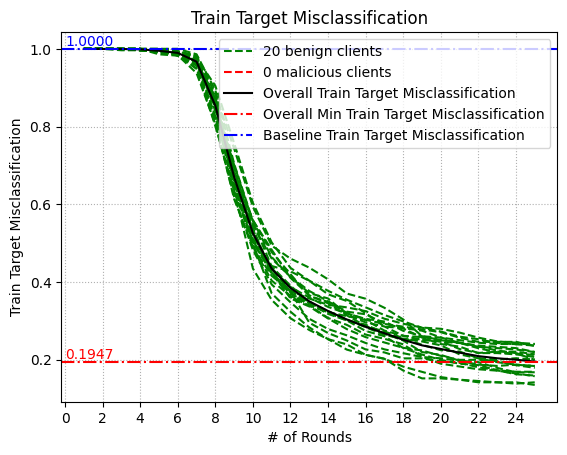

In [114]:
x = range(1, num_rounds + 1)
metric_type = "train_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

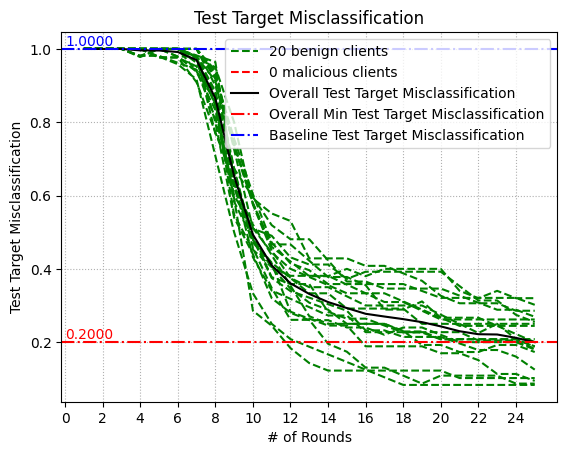

In [115]:
x = range(1, num_rounds + 1)
metric_type = "test_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()